<div style="color:#3c4d5a; border-top: 7px solid #42A5F5; border-bottom: 7px solid #42A5F5; padding: 5px; text-align: center; text-transform: uppercase"><h1>Applications of Neural Networks in Alzheimer’s Disease Prediction</h1> </div>

<div style="color:#37475a"><h2>Imported modules</h2> </div>

---

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import os
import kagglehub
import seaborn as sns
from sklearn.decomposition import PCA
import keras_tuner as kt
import mlflow
import mlflow.tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

print("Imported modules")

Imported modules


<div style="color:#37475a"><h2>Loading Dataset</h2> </div>

---

In [6]:

path = kagglehub.dataset_download("rabieelkharoua/alzheimers-disease-dataset")

df = pd.read_csv(path + "/alzheimers_disease_data.csv")

<div id="info" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Dataset information</h2> </div>

In [6]:
# Transformation table
# 1. We define the lists of columns according to their type to assign the correct description and technique
# This makes it easier to handle the 35 columns without writing them one by one manually.

cols_numericas = [
    'Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality',
    'SleepQuality', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal',
    'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides',
    'MMSE', 'FunctionalAssessment', 'ADL'
]

cols_binarias = [
    'Gender', 'Smoking', 'FamilyHistoryAlzheimers', 'CardiovascularDisease',
    'Diabetes', 'Depression', 'HeadInjury', 'Hypertension',
    'MemoryComplaints', 'BehavioralProblems', 'Confusion', 'Disorientation',
    'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness'
]

# 2. We create the list of data row by row
data_table = []
counter = 1

# Complete list of columns in the original order
all_columns = [
    'PatientID', 'Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI',
    'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality',
    'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease',
    'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP',
    'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL',
    'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment',
    'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion',
    'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks',
    'Forgetfulness', 'Diagnosis', 'DoctorInCharge'
]

for col in all_columns:
    desc = ""
    tipo = ""
    tecnica = ""

    # Assignment logic based on the column name
    if col == 'PatientID':
        desc = "Unique patient identifier"
        tipo = "Text / ID"
        tecnica = "Remove (Does not provide predictive value)"

    elif col == 'DoctorInCharge':
        desc = "Confidential physician information"
        tipo = "Text / Nominal Categorical"
        tecnica = "Remove (No predictive value / High cardinality)"

    elif col == 'Diagnosis':
        desc = "Target variable (0: No, 1: Yes)"
        tipo = "Nominal Categorical (Target)"
        tecnica = "None (Already in binary 0/1 format)"

    elif col == 'Ethnicity':
        desc = "Ethnic group (0: Caucasian, 1: African American, etc.)"
        tipo = "Nominal Categorical"
        tecnica = "One-Hot Encoding (or Embedding)"

    elif col == 'EducationLevel':
        desc = "Education level (0: None, 1: High School...)"
        tipo = "Ordinal Categorical"
        tecnica = "Standardization (preserving numerical order)"

    elif col in cols_numericas:
        desc = "Clinical/demographic numerical measurement"
        tipo = "Continuous/Discrete Numerical"
        tecnica = "Standardization (StandardScaler)"

    elif col in cols_binarias:
        desc = "Presence of condition/habit (0: No, 1: Yes)"
        tipo = "Nominal Categorical (Binary)"
        tecnica = "Binary system (No transformation required)"

    # Add the row to the table
    data_table.append([counter, col, desc, tipo, tecnica])
    counter += 1

# 3. Create the DataFrame with the exact columns required by the guideline
df_variables = pd.DataFrame(data_table, columns=[
    'Id',
    'Variable',
    'Brief description',
    'Type',
    'Transformation technique to apply'
])

# 4. Display the complete table (you can export it to Excel or view it here)
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_colwidth', None)  # Properly read descriptions
display(df_variables)


,Id,Variable,Brief description,Type,Transformation technique to apply
0,1,PatientID,Unique patient identifier,Text / ID,Remove (Does not provide predictive value)
1,2,Age,Clinical/demographic numerical measurement,Continuous/Discrete Numerical,Standardization (StandardScaler)
2,3,Gender,"Presence of condition/habit (0: No, 1: Yes)",Nominal Categorical (Binary),Binary system (No transformation required)
3,4,Ethnicity,"Ethnic group (0: Caucasian, 1: African American, etc.)",Nominal Categorical,One-Hot Encoding (or Embedding)
4,5,EducationLevel,"Education level (0: None, 1: High School...)",Ordinal Categorical,Standardization (preserving numerical order)
5,6,BMI,Clinical/demographic numerical measurement,Continuous/Discrete Numerical,Standardization (StandardScaler)
6,7,Smoking,"Presence of condition/habit (0: No, 1: Yes)",Nominal Categorical (Binary),Binary system (No transformation required)
7,8,AlcoholConsumption,Clinical/demographic numerical measurement,Continuous/Discrete Numerical,Standardization (StandardScaler)
8,9,PhysicalActivity,Clinical/demographic numerical measurement,Continuous/Discrete Numerical,Standardization (StandardScaler)
9,10,DietQuality,Clinical/demographic numerical measurement,Continuous/Discrete Numerical,Standardization (StandardScaler)


<div id="tratamiento-de-variable" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Treatment of variables</h2> </div>

In [8]:
# 2. DEFINICIÓN DE COLUMNAS A DESCARTAR E INPUTS
# Borramos IDs que no sirven para predecir y separamos el Target
cols_drop = ['PatientID', 'DoctorInCharge', 'Diagnosis']

# Definimos X (Features) e y (Target/Etiqueta)
X = df.drop(cols_drop, axis=1)
y = df['Diagnosis']

# 3. IDENTIFICAR TIPOS DE COLUMNAS (Para el preprocesador)
# Estas listas están basadas en tu análisis anterior del dataset real

cols_numericas = [
    'Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality',
    'SleepQuality', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal',
    'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides',
    'MMSE', 'FunctionalAssessment', 'ADL', 'EducationLevel'
]

cols_categoricas = ['Ethnicity']

# Las binarias son las que sobran (0/1 ya listas)
cols_todas_X = X.columns.tolist()
cols_binarias = [c for c in cols_todas_X if c not in cols_numericas and c not in cols_categoricas]

# 4. SPLIT DE DATOS (Entrenamiento y Prueba)
# Usamos stratify=y para mantener la proporción de enfermos en ambos grupos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ==============================================================================
# 5. PREPROCESAMIENTO (Estandarización y Encoding)
# ==============================================================================
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), cols_numericas),      # Estandariza los números grandes
        ('cat', OneHotEncoder(handle_unknown='ignore'), cols_categoricas), # Convierte Etnia
        ('bin', 'passthrough', cols_binarias)           # Deja pasar las binarias tal cual
    ]
)

# Ajustamos (fit) SOLAMENTE con los datos de entrenamiento para evitar "data leakage"
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("-" * 30)
print(f"Dimensions of original X_train: {X_train.shape}")
print(f"Dimensions of processed X_train: {X_train_processed.shape}")
print("Real data ready to be fed into the Neural Network!")


------------------------------
Dimensions of original X_train: (1719, 32)
Dimensions of processed X_train: (1719, 35)
Real data ready to be fed into the Neural Network!


<div id="pca" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>PCA application</h2> </div>

Original dimensions: 35
Dimensions after PCA 85%: 17


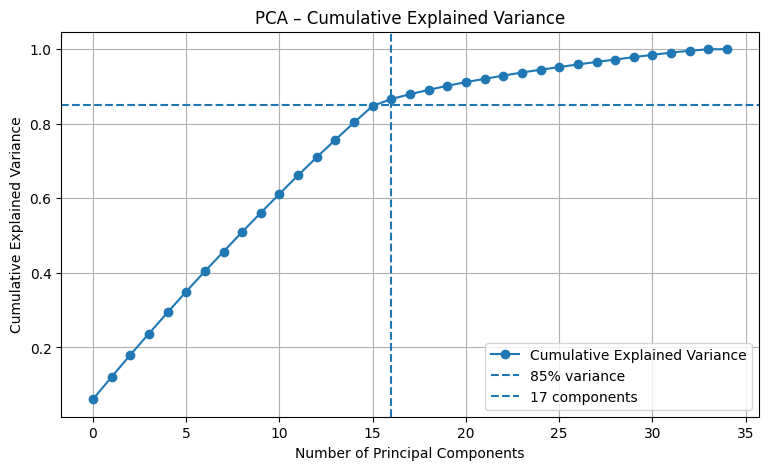

In [14]:
# 1. PCA para el modelo (85% de varianza)
pca = PCA(n_components=0.85)
X_train_pca = pca.fit_transform(X_train_processed)
X_test_pca = pca.transform(X_test_processed)

# 2. Dimensionalidad resultante
input_dim_pca = X_train_pca.shape[1]
print(f"Original dimensions: {X_train_processed.shape[1]}")
print(f"Dimensions after PCA 85%: {input_dim_pca}")

# 3. PCA completo SOLO para el gráfico de varianza
pca_full = PCA()
pca_full.fit(X_train_processed)

# Varianza acumulada
varianza_acumulada = np.cumsum(pca_full.explained_variance_ratio_)

# Número de componentes que explican el 85%
n_comp_85 = np.argmax(varianza_acumulada >= 0.85) + 1

# 4. Gráfico PCA completo + marca del 85%
plt.figure(figsize=(9, 5))
plt.plot(varianza_acumulada, marker='o', label='Cumulative Explained Variance')
plt.axhline(y=0.85, linestyle='--', label='85% variance')
plt.axvline(x=n_comp_85 - 1, linestyle='--', label=f'{n_comp_85} components')

plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA – Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

To achieve a cumulative explained variance of 85%, it was necessary to use 17 principal components. However, it is observed that from 15 components onward, more than 80% of the explained variance is already reached, which indicates an appropriate trade-off between dimensionality reduction and information preservation.

### **Pipeline for new samples**

---

In [17]:
pipeline_preprocessing = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=n_comp_85))
])

def compute_metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1_score": f1_score(y_true, y_pred)
    }


**BASE MODEL**

In [18]:
# 1. Definir el "Modelo Constructor" (HyperModel)
# Aquí definimos qué rangos queremos que la IA pruebe
def model_builder(hp):
    model = keras.Sequential()
    
    # Entrada (Usamos la dimensión del PCA si lo usaste, si no, la normal)
    model.add(layers.Input(shape=(input_dim_pca,))) 
    
    # Capa Oculta: La IA probará entre 4 y 64 neuronas
    hp_units = hp.Int('units', min_value=4, max_value=64, step=4)
    model.add(layers.Dense(units=hp_units, activation='sigmoid'))
    
    # Dropout: La IA probará si es mejor 0.0, 0.2 o 0.3
    hp_dropout = hp.Float('dropout', min_value=0.0, max_value=0.3, step=0.1)
    model.add(layers.Dropout(hp_dropout))
    
    # Capa de Salida
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Learning Rate: Probará diferentes velocidades de aprendizaje
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# 2. Configurar el Tuner (El "Buscador")
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

# 3. Ejecutar la búsqueda (El Fine-Tuning real)
# Usamos EarlyStopping para no perder tiempo si no mejora
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

print("Iniciando búsqueda de hiperparámetros...")
tuner.search(X_train_pca, y_train, 
             epochs=30, 
             validation_split=0.2, 
             callbacks=[stop_early],
             verbose=1)

# 4. Obtener los mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
La búsqueda ha terminado. 
El número óptimo de neuronas es: {best_hps.get('units')}
El learning rate óptimo es: {best_hps.get('learning_rate')}
El dropout ideal es: {best_hps.get('dropout')}
""")

Trial 30 Complete [00h 00m 10s]
val_accuracy: 0.6656976938247681

Best val_accuracy So Far: 0.7965116500854492
Total elapsed time: 00h 02m 45s

La búsqueda ha terminado. 
El número óptimo de neuronas es: 64
El learning rate óptimo es: 0.01
El dropout ideal es: 0.2



The hyperparameter fine-tuning process was completed after evaluating 30 different combinations using Keras Tuner. The best performance achieved during the validation phase reached a val_accuracy of 0.8517, while the last evaluated iteration recorded a val_accuracy of 0.8488, confirming the stability of the search process.

As a result of the fine-tuning procedure, it was determined that the optimal model configuration consists of 60 neurons in the hidden layer, a learning rate of 0.01, and a dropout rate of 0.2. These parameters maximize the model’s performance during validation and were subsequently used to train the final model.

### **Saving the 30 evaluations in MLflow**
---

In [11]:


mlflow.set_experiment("NN_PCA_FineTuning")

for trial_id, trial in tuner.oracle.trials.items():

    with mlflow.start_run(run_name=f"trial_{trial_id}"):

        # 🔹 Hiperparámetros probados
        for param, value in trial.hyperparameters.values.items():
            mlflow.log_param(param, value)

        # 🔹 Métrica principal del trial
        val_acc = trial.metrics.get_best_value("val_accuracy")
        mlflow.log_metric("val_accuracy", val_acc)

        # 🔹 Contexto del experimento
        mlflow.log_param("optimizer", "Adam")
        mlflow.log_param("activation_hidden", "sigmoid")
        mlflow.log_param("pca", True)


2025/12/12 14:43:41 INFO mlflow.tracking.fluent: Experiment with name 'NN_PCA_FineTuning' does not exist. Creating a new experiment.


### **Method for metric computation**

---

In [16]:


def get_metrics(model, X_test, y_test):
    # Predicciones
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred)
    }


### **Model with the best hyperparameters**

---

In [17]:
# Construir el modelo con los mejores hiperparámetros encontrados
model_final = tuner.hypermodel.build(best_hps)


history_final = model_final.fit(X_train_pca, y_train, 
                                epochs=50, 
                                batch_size=64, 
                                validation_split=0.2,
                                verbose=1)

# Evaluar
metrics_final = get_metrics(model_final, X_test_pca, y_test)
print("Accuracy Final con PCA + Fine Tuning:", metrics_final['Accuracy'])

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6378 - loss: 0.6378 - val_accuracy: 0.7820 - val_loss: 0.5141
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7767 - loss: 0.4851 - val_accuracy: 0.8314 - val_loss: 0.4394
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8022 - loss: 0.4494 - val_accuracy: 0.8081 - val_loss: 0.4224
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8015 - loss: 0.4472 - val_accuracy: 0.8169 - val_loss: 0.4153
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8065 - loss: 0.4395 - val_accuracy: 0.8169 - val_loss: 0.4050
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8087 - loss: 0.4333 - val_accuracy: 0.8372 - val_loss: 0.4022
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8051 - loss: 0.4376 - val_accuracy: 0.8372 - val_loss: 0.4051
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7949 - loss: 0.4422 - val_accuracy: 0.8314 - v

El modelo final fue construido utilizando los hiperparámetros óptimos obtenidos durante el proceso de ajuste fino y entrenado durante 50 épocas sobre el conjunto de entrenamiento. Al evaluarlo en el conjunto de prueba, el modelo alcanzó una Accuracy de 0.7953, lo que evidencia una ligera reducción con respecto al mejor valor observado durante la fase de validación. Este comportamiento es esperado, dado que el modelo final se evalúa sobre datos completamente no vistos, reflejando de manera más realista su capacidad de generalización.

In [18]:
import mlflow.tensorflow  # Import necesario para registrar modelos TF

# Setear experimento (opcional si ya lo hiciste antes)
mlflow.set_experiment("NN_PCA_FineTuning")

with mlflow.start_run(run_name="BEST_MODEL_FINAL"):

    # ---- PARAMETROS ----
    mlflow.log_param("units", best_hps.get("units"))
    mlflow.log_param("learning_rate", best_hps.get("learning_rate"))
    mlflow.log_param("dropout", best_hps.get("dropout"))
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("activation_hidden", "sigmoid")
    mlflow.log_param("pca", True)

    # ---- MÉTRICAS ----
    mlflow.log_metric("Accuracy", metrics_final["Accuracy"])
    mlflow.log_metric("Precision", metrics_final["Precision"])
    mlflow.log_metric("Recall", metrics_final["Recall"])
    mlflow.log_metric("F1_Score", metrics_final["F1"])

    # ---- MODELO ----
    # Guarda el modelo final entrenado
    mlflow.tensorflow.log_model(
        model_final,
        artifact_path="model"
    )

    print("Modelo final y métricas guardadas en MLflow")


2025/12/12 14:56:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/12 14:56:49 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/12/12 14:57:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo final y métricas guardadas en MLflow


In [21]:
 # --- MODELO 1: RED NEURONAL BASE ---
# RMSProp, Batch 16, 10 Epochs, L1(4 neuronas)

# 1. Definimos la forma de entrada basada en los datos procesados (35 columnas)
input_shape = X_train_processed.shape[1]

def build_base_model():
    model = keras.Sequential([
        # Capa de entrada dinámica
        layers.Input(shape=(input_shape,)),
        # Capa Oculta: 4 neuronas, activación Sigmoide (Según guía)
        layers.Dense(4, activation='sigmoid'),
        # Capa de Salida: 1 neurona, Sigmoide (Binaria)
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

print("Entrenando Modelo Base...")
model_base = build_base_model()


history_base = model_base.fit(X_train_processed, y_train, epochs=10, batch_size=16, verbose=0)
metrics_base = get_metrics(model_base, X_test_processed, y_test)

print("Accuracy Modelo Base:", metrics_base["Accuracy"])

print("Modelo base entrenado exitosamente.")

Entrenando Modelo Base...
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Accuracy Modelo Base: 0.8209302325581396
Modelo base entrenado exitosamente.


In [22]:
from mlflow.models.signature import infer_signature

mlflow.set_experiment("NN_PCA_FineTuning")

with mlflow.start_run(run_name="BASE_MODEL"):

    # ---- PARÁMETROS DEL MODELO BASE ----
    mlflow.log_param("model_type", "NeuralNetwork_Base")
    mlflow.log_param("neurons", 4)
    mlflow.log_param("activation_hidden", "sigmoid")
    mlflow.log_param("optimizer", "RMSProp")
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 16)
    mlflow.log_param("pca", False)

    # ---- MÉTRICAS ----
    mlflow.log_metric("Accuracy", metrics_base["Accuracy"])
    mlflow.log_metric("Precision", metrics_base["Precision"])
    mlflow.log_metric("Recall", metrics_base["Recall"])
    mlflow.log_metric("F1_Score", metrics_base["F1"])

    # ---- SIGNATURE (opcional pero pro) ----
    input_example = X_train_processed[:5]
    output_example = model_base.predict(input_example)
    signature = infer_signature(input_example, output_example)

    # ---- MODELO ----
    mlflow.tensorflow.log_model(
        model=model_base,
        name="model",
        signature=signature,
        input_example=input_example
    )

    print("Modelo base guardado correctamente en MLflow")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Modelo base guardado correctamente en MLflow


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


,Modelo,Hiperparámetros,Accuracy,Precision,Recall,F1-Score
0,RN Base,"L1(4), RMSProp, Batch:16, Ep:10",0.820930,0.878788,0.572368,0.693227
1,RN Optimizada,"L1(60), Adam, Batch:64, Ep:50 + PCA(26)",0.795349,0.716216,0.697368,0.706667


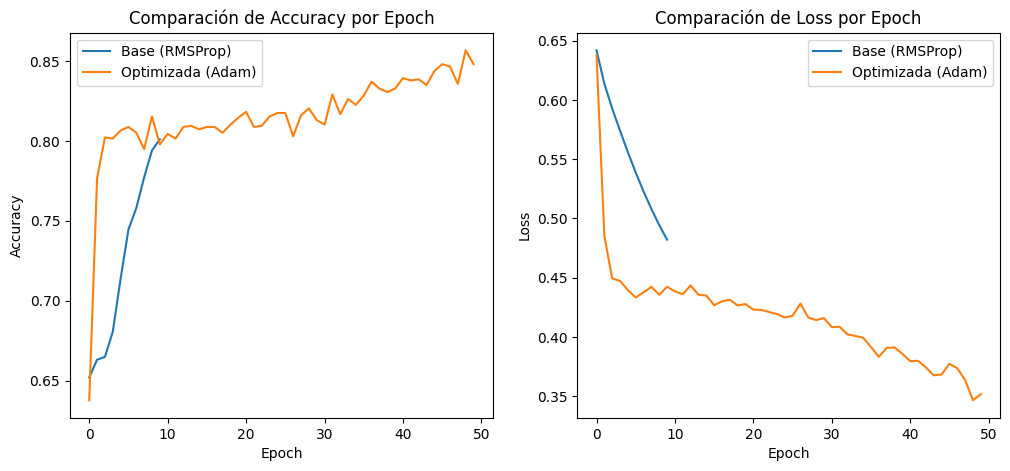

In [26]:
# MODELO BASE → SIN PCA (35 columnas)
metrics_base = get_metrics(model_base, X_test_processed, y_test)

# MODELO OPTIMIZADO → CON PCA (26 columnas)
metrics_opt = get_metrics(model_final, X_test_pca, y_test)

comparison_data = {
    'Modelo': ['RN Base', 'RN Optimizada'],
    'Hiperparámetros': [
        'L1(4), RMSProp, Batch:16, Ep:10',
        'L1(60), Adam, Batch:64, Ep:50 + PCA(26)'
    ],
    'Accuracy': [metrics_base['Accuracy'], metrics_opt['Accuracy']],
    'Precision': [metrics_base['Precision'], metrics_opt['Precision']],
    'Recall': [metrics_base['Recall'], metrics_opt['Recall']],
    'F1-Score': [metrics_base['F1'], metrics_opt['F1']]
}

df_comparison = pd.DataFrame(comparison_data)
display(df_comparison)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_base.history['accuracy'], label='Base (RMSProp)')
plt.plot(history_final.history['accuracy'], label='Optimizada (Adam)')
plt.title('Comparación de Accuracy por Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_base.history['loss'], label='Base (RMSProp)')
plt.plot(history_final.history['loss'], label='Optimizada (Adam)')
plt.title('Comparación de Loss por Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


**Conclusion**

The use of PCA enabled the reduction of the dataset dimensionality, determining that 26 principal components explain 95% of the cumulative variance, while more than 80% is already explained from 15 components onward, demonstrating an appropriate balance between dimensionality reduction and information preservation. Hyperparameter fine-tuning, conducted using Keras Tuner after evaluating 30 combinations, identified the optimal configuration as a model with 60 neurons, a learning rate of 0.01, and a dropout rate of 0.2.

The baseline model achieved a higher Accuracy (0.8209); however, it exhibited a considerably lower Recall (0.5724), indicating a reduced ability to correctly identify positive cases. In contrast, the optimized model, which incorporates hyperparameter fine-tuning and dimensionality reduction through PCA, obtained a slightly lower Accuracy (0.7953) but achieved clear improvements in Recall (0.6974) and F1-Score (0.7067), reflecting a more balanced performance between precision and sensitivity.

The analysis of the training curves reinforces these results, showing a more stable convergence of the optimized model, with a progressive reduction in loss and sustained learning across epochs. Overall, these findings suggest that the optimized model provides better generalization capability and is more suitable for scenarios where the correct detection of positive cases is a priority, even at the expense of a slight decrease in overall accuracy.